In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## print out the names of the first 5 image_files (total = 10 images for train_imgaes & train_label_masks) with the train, test, submission.csv files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prostate-cancer-grade-assessment/sample_submission.csv
/kaggle/input/prostate-cancer-grade-assessment/test.csv
/kaggle/input/prostate-cancer-grade-assessment/train.csv
/kaggle/input/prostate-cancer-grade-assessment/train_images/2673584f9398ce0acb21a86a1a711088.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/5d46da93924a4b15472581eb39658309.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/35e8dd323072ad8efa1ae1db44921669.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/a807e743ad2020d229347aede1882a8f.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_images/95c518378ccd428a5e674c3c668e9f2e.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/9bce8bb47c22ab502ed7266e2e3762c0_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/124a0616099409f5b9aaedfd3ac3ab6d_mask.tiff
/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/8b1590bb6429c7b3bbbcf0a420fff72d_mask.tiff
/kag

In [4]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

In [5]:
# Location of the training images

BASE_PATH = '../input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')

train_labels = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')

submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

In [6]:
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [7]:
print("Shape of training data :", train.shape)
print("Mainly information of training data :", train.info())
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

Shape of training data : (10616, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 10616 entries, 0005f7aaab2800f6170c399693a96917 to ffe9bcababc858e04840669e788065a1
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   data_provider  10616 non-null  object
 1   isup_grade     10616 non-null  int64 
 2   gleason_score  10616 non-null  object
dtypes: int64(1), object(2)
memory usage: 331.8+ KB
Mainly information of training data : None
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


In [8]:
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


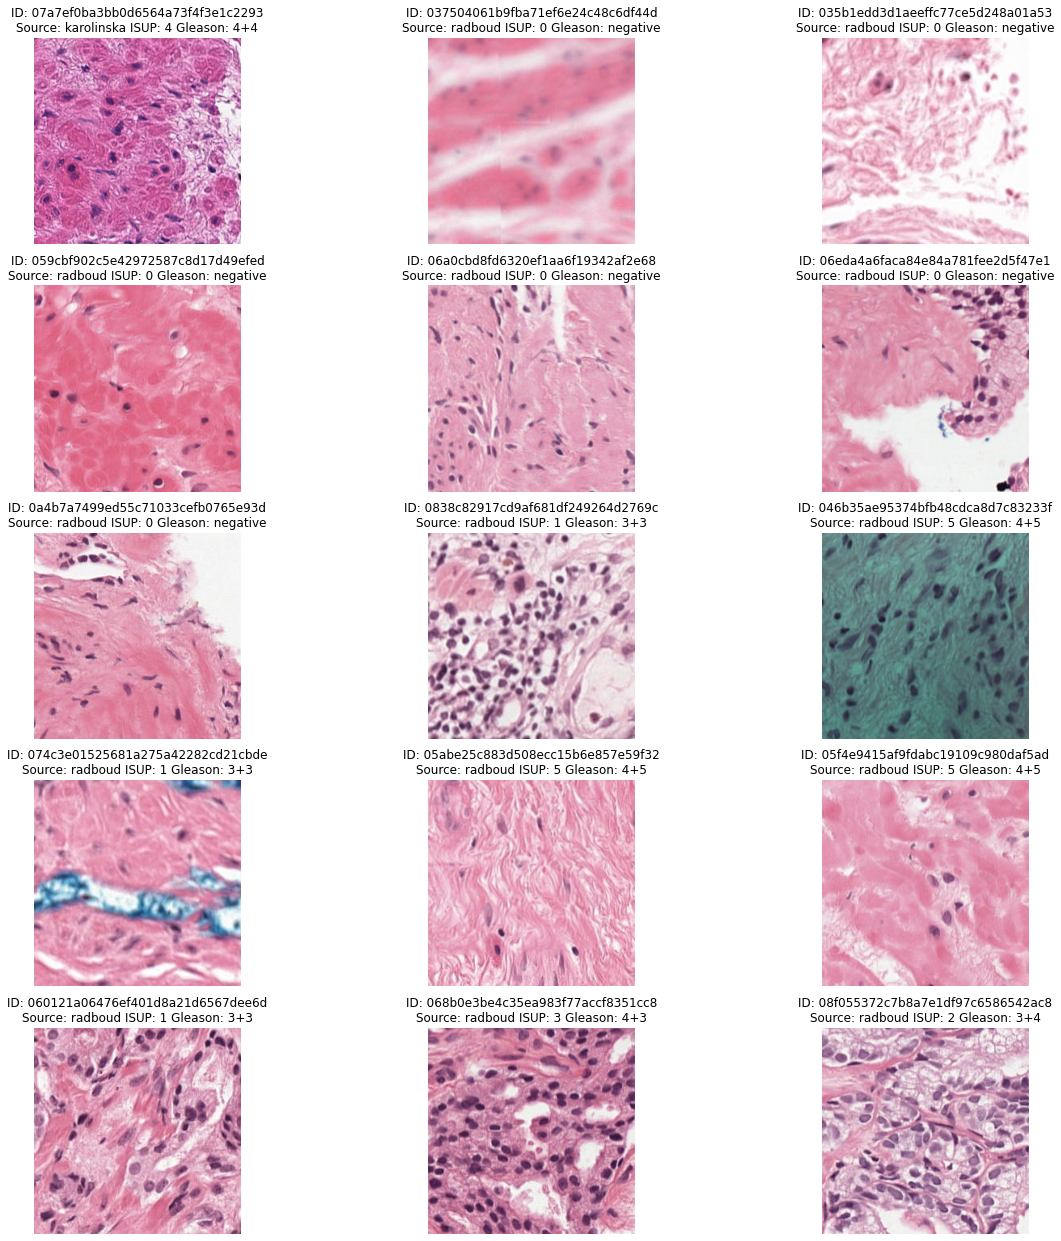

In [9]:
def display_images(slides): 
    f, ax = plt.subplots(5,3, figsize=(20, 22))
    for i, slide in enumerate(slides):
        image = openslide.OpenSlide(os.path.join(data_dir, f'{slide}.tiff'))
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region((1780,1950), 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show() 
    
images = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]

display_images(images)

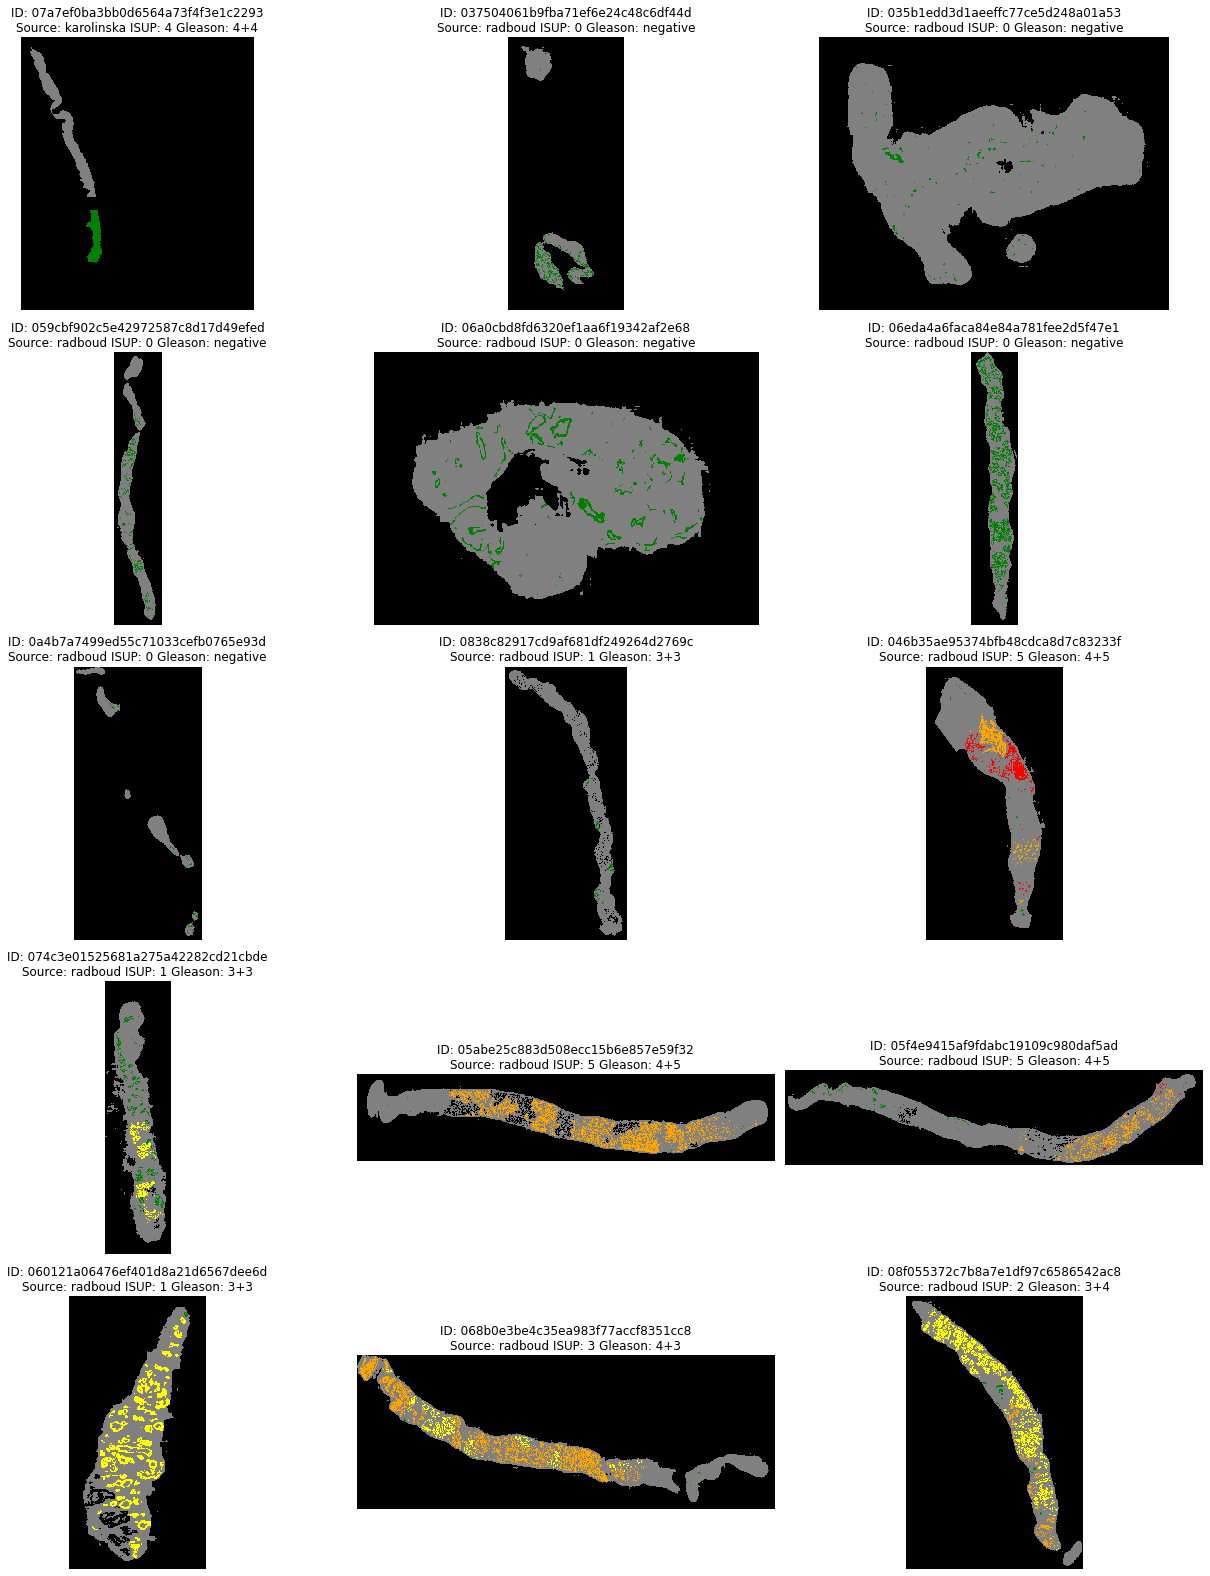

In [10]:
def display_masks(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{slide}_mask.tiff'))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()
    
display_masks(images)

### Split the images

#### Drafting.

In [11]:
from skimage.io import imread
import imagecodecs

%time img = imread(os.path.join(data_dir, '004dd32d9cd167d9cc31c13b704498af.tiff'))
img.shape

CPU times: user 1.35 s, sys: 926 ms, total: 2.28 s
Wall time: 1.23 s


(22528, 8192, 3)

CPU times: user 2.53 s, sys: 643 ms, total: 3.17 s
Wall time: 3.17 s


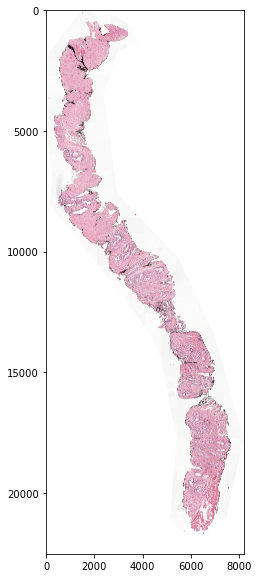

In [12]:
plt.figure(figsize = (10, 10))
%time plt.imshow(img)

width_start_at: 0 	 width_end_at: 11264 	 height_start_at: 0 	 height_end_at: 2730 	 No_img: 1
width_start_at: 0 	 width_end_at: 11264 	 height_start_at: 2730 	 height_end_at: 5461 	 No_img: 2
width_start_at: 0 	 width_end_at: 11264 	 height_start_at: 5461 	 height_end_at: 8192 	 No_img: 3
width_start_at: 11264 	 width_end_at: 22528 	 height_start_at: 0 	 height_end_at: 2730 	 No_img: 3
width_start_at: 11264 	 width_end_at: 22528 	 height_start_at: 2730 	 height_end_at: 5461 	 No_img: 4
width_start_at: 11264 	 width_end_at: 22528 	 height_start_at: 5461 	 height_end_at: 8192 	 No_img: 5


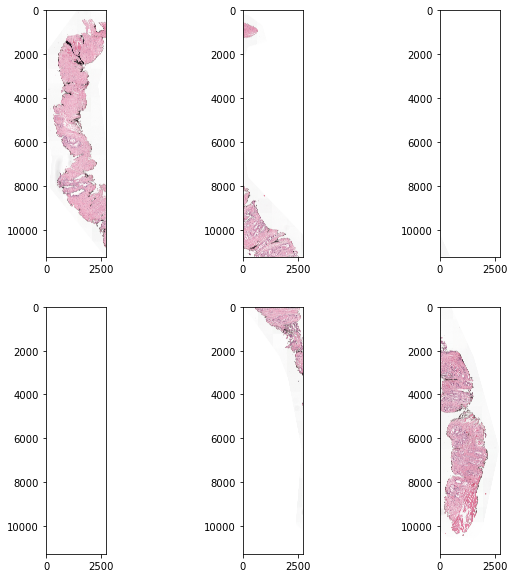

In [18]:
nr, nc = 2, 3
h, w = img.shape[: 2]
img_ls = []
for i in range(nr):
    for j in range(nc):
        print('width_start_at:', int(i*h/nr), '\t width_end_at:' , int((i+1)*h/nr), '\t height_start_at:', int(j*w/nc) , '\t height_end_at:', int((j+1)*w/nc), '\t No_img:', i*nr+ j + 1)
        img_ls.append(img[ int(i*h/nr) : int((i+1)*h/nr), int(j*w/nc) : int((j+1)*w/nc), :])

plt.figure(figsize = (10, 10))
for i in range(nr*nc):
    plt.subplot(nr, nc, i + 1)
    plt.imshow(img_ls[i])

#### Build a function for spliting

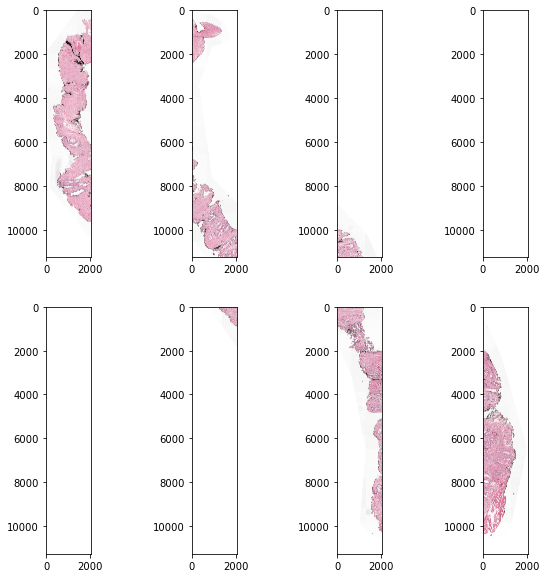

In [14]:
def display_img_spliting(img, nr, nc, fs):
    ## img : image source
    ## nr, nc : number of rows & columns at the subplot for spliting
    ## fs: figsize
    h, w = img.shape[: 2]
    img_ls = []
    for i in range(nr):
        for j in range(nc):
            img_ls.append(img[ int(i*h/nr) : int((i+1)*h/nr), int(j*w/nc) : int((j+1)*w/nc), :])

    plt.figure(figsize = fs)
    for i in range(nr*nc):
        plt.subplot(nr, nc, i + 1)
        plt.imshow(img_ls[i])
        
display_img_spliting(img, 2, 4, (10, 10))

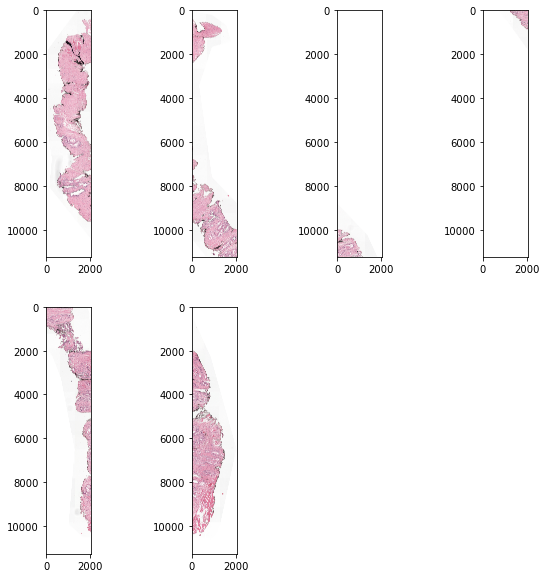

In [26]:
def display_img_spliting_v2(img, nr, nc, fs):
    ## img : image source
    ## nr, nc : number of rows & columns at the subplot for spliting
    ## fs: figsize
    h, w = img.shape[: 2]
    img_ls = []
    for i in range(nr):
        for j in range(nc):
            image = img[ int(i*h/nr) : int((i+1)*h/nr), int(j*w/nc) : int((j+1)*w/nc), :]
            if image.min() != image.max():
                img_ls.append(image)

    plt.figure(figsize = fs)
    for i in range(len(img_ls)):
        plt.subplot(nr, nc, i + 1)
        plt.imshow(img_ls[i])
        
display_img_spliting_v2(img, 2, 4, (10, 10))

In [ ]:
display_img_spliting_v2(img, 4, 4, (20, 20))

#### Loading